In [0]:
import tensorflow as tf
import tensorflow_datasets as tfds

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os

## Downloading the Data

The dataset is available at https://www.kaggle.com/abhinavmoudgil95/short-jokes/data

Sign In to Kaggle and begin the download process for **shortjokes.csv** file. Then copy the link address for the download file and update the _URL varaiable.

Once done run all the cells in the notebook. Also, you can cancel the donwload process for the file. :)

In [0]:
_URL = 'https://storage.googleapis.com/kaggle-data-sets/781%2F1457%2Fcompressed%2Fshortjokes.csv.zip?GoogleAccessId=gcp-kaggle-com@kaggle-161607.iam.gserviceaccount.com&Expires=1591366620&Signature=B62abmVrT%2BrxZx98Vr4GcGpSGV8nTSmQVG7qBr771XvAfs7lQIgg0OQNGmhHAJ3BUlXTdTPh93RH45jtojG7qdec86oV%2FyXYk6HxyvDZgNzkC6vQsZv7A4WFt1Q9EZPBzhimECVrGwq5KwmwSDPntEYiZwQ9xHOvyefomUhLkUYpoi5xFbf%2BO79c2iAekgwbYLyAG%2BTNmVF4CGBCnlj%2F%2FqYT0anHefFnIfQ26msN3njQEq%2BMPLafSNAWGZYeZmvX8TAIZqkHz8VlgnpahK%2Bp3%2B0WUTWSTlii03q1JcAumVwB%2Fg2uByPlASohVNqqd1pkpLRpVuSsA%2BewR%2BdyGobhDw%3D%3D'

In [0]:
path_to_zip = tf.keras.utils.get_file('shortjokes.csv.zip', origin=_URL, extract=True)

FILE_PATH = os.path.join(os.path.dirname(path_to_zip), 'shortjokes.csv')

10305536/10299687 [==============================] - 0s 0us/step


## Preparing the Data

### Extracting jokes list from CSV

In [0]:
jokes = pd.read_csv(FILE_PATH)
jokes.head()

,ID,Joke
0,1,"[me narrating a documentary about narrators] ""..."
1,2,Telling my daughter garlic is good for you. Go...
2,3,I've been going through a really rough period ...
3,4,"If I could have dinner with anyone, dead or al..."
4,5,Two guys walk into a bar. The third guy ducks.


In [0]:
jokeslist = jokes['Joke'].to_list()
jokeslist = jokeslist[:20000]

### Creating the Tokenizer

In [0]:
tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(
      jokeslist,
      target_vocab_size=len(jokeslist)
  )

In [0]:
# Define start and end token to indicate the start and end of a sentence
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

# Vocabulary size plus start and end token
VOCAB_SIZE = tokenizer.vocab_size + 2

In [0]:
MAX_LENGTH = 64


def tokenize(sentence_list):
  
  tokenized_sentence_list = [
    START_TOKEN + tokenizer.encode(sentence) + END_TOKEN \
    for sentence in sentence_list
  ]

  padded_list = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_sentence_list, maxlen = MAX_LENGTH, padding='post'
  )


  return padded_list

In [0]:
jokes_as_tokens = tokenize(jokeslist)

In [0]:
jokes_as_tokens[0]

array([19357, 19192,    34, 14735,     1,  4247,    48, 14736,  4310,
       19216,   683,     3,    97, 19140,    14,   126,    76,   166,
       19140,    57,   791,  2222, 19174, 19140,    36,  3676, 19135,
       19358,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [0]:
# A utility method to create a tf.data dataset from a List of jokes
def tokenslist_to_dataset(tokens_list, 
                  shuffle=True, batch_size=16):

  dataset = tf.data.Dataset.from_tensor_slices(( 
          tokens_list[:, :-1],
          tokens_list[:, 1:]
  ))

  if shuffle:
    dataset = dataset.shuffle(buffer_size=len(tokens_list))

  dataset = dataset.batch(batch_size)

  return dataset

In [0]:
jokes_dataset = tokenslist_to_dataset(jokes_as_tokens)

In [0]:
for batchX, batchY in jokes_dataset:
  print(batchX[0], batchY[0])
  break

tf.Tensor(
[19357    17    65     1  1785   181    20    37    19  5864 19216     4
  9613 16071  1254 19147 19358     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0], shape=(63,), dtype=int32) tf.Tensor(
[   17    65     1  1785   181    20    37    19  5864 19216     4  9613
 16071  1254 19147 19358     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0], shape=(63,), dtype=int32)


## Attention

### Scaled dot product Attention

The scaled dot-product attention function used by the transformer takes three inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:

$$\Large{Attention(Q, K, V) = softmax_k(\frac{QK^T}{\sqrt{d_k}}) V} $$

As the softmax normalization is done on the `key`, its values decide the amount of importance given to the `query`.

The output represents the multiplication of the attention weights and the `value` vector. This ensures that the words we want to focus on are kept as is and the irrelevant words are flushed out.

The dot-product attention is scaled by a factor of square root of the depth. This is done because for large values of depth, the dot product grows large in magnitude pushing the softmax function where it has small gradients resulting in a very hard softmax. 

For example, consider that `query` and `key` have a mean of 0 and variance of 1. Their matrix multiplication will have a mean of 0 and variance of `dk`. Hence, *square root of `dk`* is used for scaling (and not any other number) because the matmul of `query` and `key` should have a mean of 0 and variance of 1, so that we get a gentler softmax.

The mask is multiplied with *-1e9 (close to negative infinity).* This is done because the mask is summed with the scaled matrix multiplication of `query` and `key` and is applied immediately before a softmax. The goal is to zero out these cells, and large negative inputs to softmax are near zero in the output.

In [0]:
def scaled_dot_product_attention(query, key, value, mask):
  """Calculate the attention weights. """
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # scale matmul_qk
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # add the mask to zero out padding tokens
  if mask is not None:
    logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k)
  attention_weights = tf.nn.softmax(logits, axis=-1)

  output = tf.matmul(attention_weights, value)

  return output

### Multi-head attention

<img src="https://www.tensorflow.org/images/tutorials/transformer/multi_head_attention.png" width="500" alt="multi-head attention">


Multi-head attention consists of four parts:
* Linear layers and split into heads.
* Scaled dot-product attention.
* Concatenation of heads.
* Final linear layer.

Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads. 

The `scaled_dot_product_attention` defined above is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step.  The attention output for each head is then concatenated (using `tf.transpose`, and `tf.reshape`) and put through a final `Dense` layer.

Instead of one single attention head, `query`, `key`, and `value` are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [0]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # linear layers
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # split heads
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # scaled dot-product attention
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # concatenation of heads
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # final linear layer
    outputs = self.dense(concat_attention)

    return outputs

## Transformer

### Masking

`create_padding_mask` and `create_look_ahead` are helper functions to creating masks to mask out padded tokens, we are going to use these helper functions as `tf.keras.layers.Lambda` layers.

Mask all the pad tokens (value `0`) in the batch to ensure the model does not treat padding as input.

In [0]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]

In [0]:
print(create_padding_mask(tf.constant([[1, 2, 0, 3, 0], [0, 0, 0, 4, 5]])))

tf.Tensor(
[[[[0. 0. 1. 0. 1.]]]


 [[[1. 1. 1. 0. 0.]]]], shape=(2, 1, 1, 5), dtype=float32)


Look-ahead mask to mask the future tokens in a sequence.
We also mask out pad tokens.

i.e. To predict the third word, only the first and second word will be used

In [0]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)

In [0]:
print(create_look_ahead_mask(tf.constant([[1, 2, 0, 4, 5]])))

tf.Tensor(
[[[[0. 1. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 1. 1.]
   [0. 0. 1. 0. 1.]
   [0. 0. 1. 0. 0.]]]], shape=(1, 1, 5, 5), dtype=float32)


### Positional encoding

Since this model doesn't contain any recurrence or convolution, positional encoding is added to give the model some information about the relative position of the words in the sentence. 

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of words in a sentence. So after adding the positional encoding, words will be closer to each other based on the *similarity of their meaning and their position in the sentence*, in the d-dimensional space.

See the notebook on [positional encoding](https://github.com/tensorflow/examples/blob/master/community/en/position_encoding.ipynb) to learn more about it. The formula for calculating the positional encoding is as follows:

$$\Large{PE_{(pos, 2i)} = sin(pos / 10000^{2i / d_{model}})} $$
$$\Large{PE_{(pos, 2i+1)} = cos(pos / 10000^{2i / d_{model}})} $$

In [0]:
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)
    # apply sin to even index in the array
    sines = tf.math.sin(angle_rads[:, 0::2])
    # apply cos to odd index in the array
    cosines = tf.math.cos(angle_rads[:, 1::2])

    pos_encoding = tf.concat([sines, cosines], axis=-1)
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

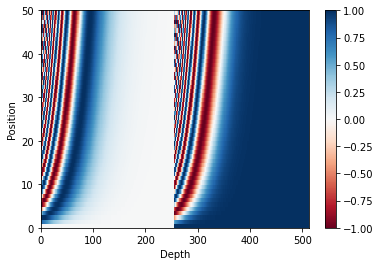

In [0]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

### Decoder Layer

Each decoder layer consists of sublayers:

1.   Masked multi-head attention (with look ahead mask and padding mask)
2.   Multi-head attention (with padding mask). `value` and `key` receive the *encoder output* as inputs. `query` receives the *output from the masked multi-head attention sublayer.*
3.   2 dense layers followed by dropout

Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is `LayerNorm(x + Sublayer(x))`. The normalization is done on the `d_model` (last) axis.

As `query` receives the output from decoder's first attention block, and `key` receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output. See the demonstration above in the scaled dot product attention section.

In [0]:
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")

  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)


  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

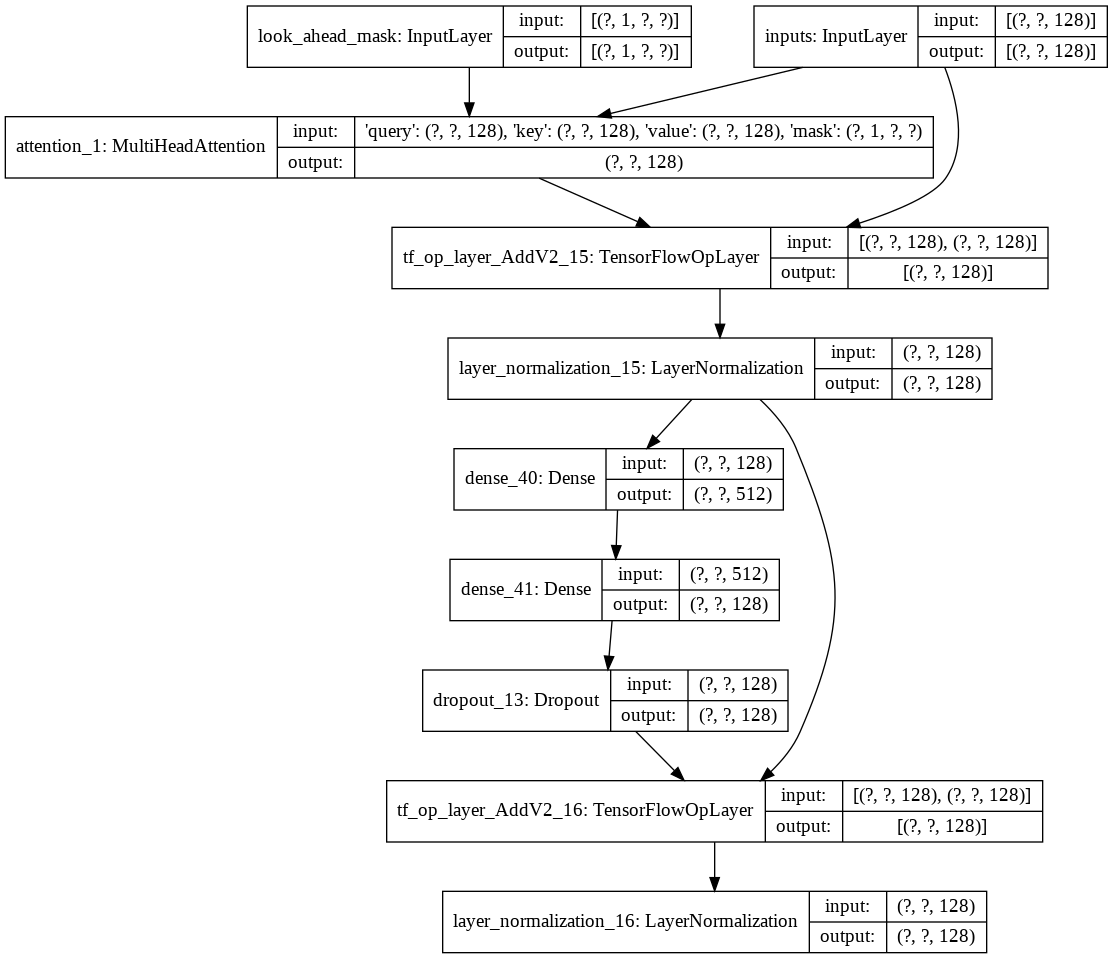

In [0]:
sample_decoder_layer = decoder_layer(
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder_layer")

tf.keras.utils.plot_model(
    sample_decoder_layer, to_file='decoder_layer.png', show_shapes=True)

### Decoder

The Decoder consists of:
1.   Output Embedding
2.   Positional Encoding
3.   N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [0]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='language decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')
  
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs,  look_ahead_mask])

  return tf.keras.Model(
      inputs=[inputs, look_ahead_mask],
      outputs=outputs,
      name=name)

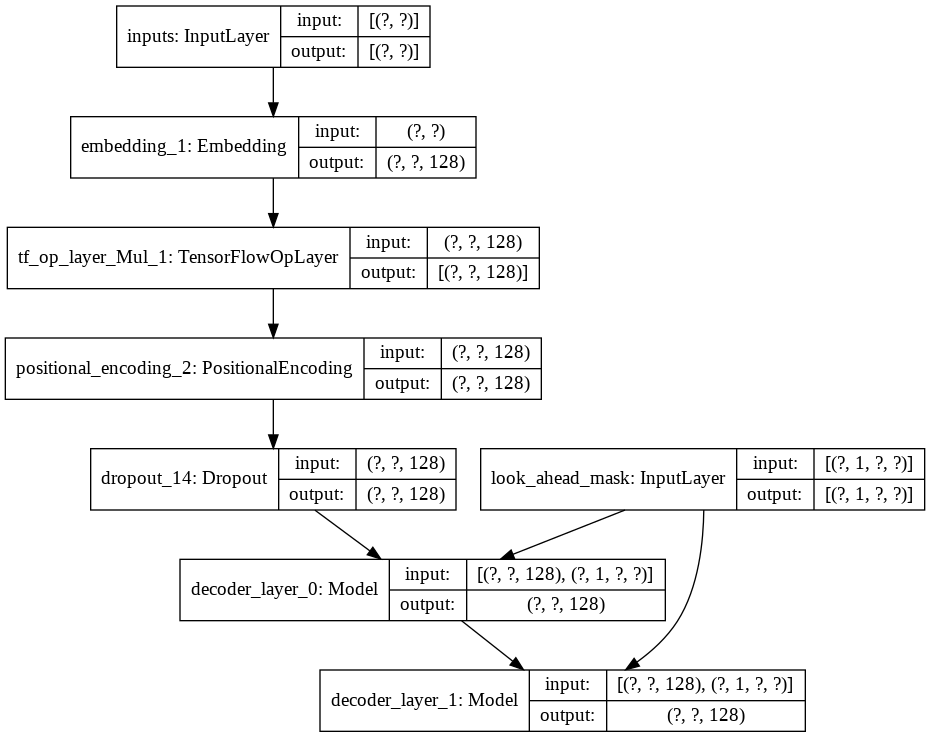

In [0]:
sample_decoder = decoder(
    vocab_size=8192,
    num_layers=2,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_decoder")

tf.keras.utils.plot_model(
    sample_decoder, to_file='decoder.png', show_shapes=True)

### Transformer

Transformer consists of the encoder, decoder and a final linear layer. The output of the decoder is the input to the linear layer and its output is returned.

In [0]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # mask the future tokens for decoder inputs at the 1st attention block
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(inputs)
 

  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, look_ahead_mask])

  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=inputs, outputs=outputs, name=name)

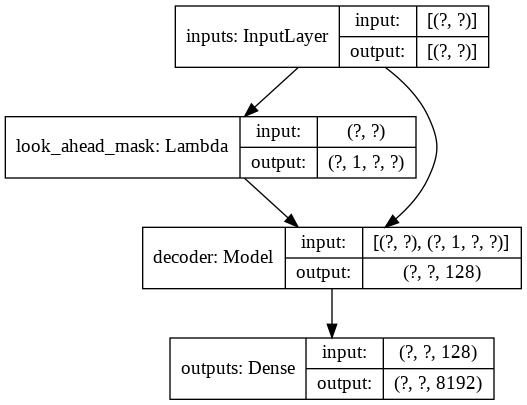

In [0]:
sample_transformer = transformer(
    vocab_size=8192,
    num_layers=4,
    units=512,
    d_model=128,
    num_heads=4,
    dropout=0.3,
    name="sample_transformer")

tf.keras.utils.plot_model(
    sample_transformer, to_file='transformer.png', show_shapes=True)

## Train model

### Initialize model

To keep this example small and relatively fast, the values for *num_layers, d_model, and units* have been reduced. See the [paper](https://arxiv.org/abs/1706.03762) for all the other versions of the transformer.

In [0]:
tf.keras.backend.clear_session()

# Hyper-parameters
NUM_LAYERS = 8
D_MODEL = 256
NUM_HEADS = 8
UNITS = 512
DROPOUT = 0.1

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

### Loss function

Since the target sequences are padded, it is important to apply a padding mask when calculating the loss.

In [0]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)

### Custom learning rate

Use the Adam optimizer with a custom learning rate scheduler according to the formula in the [paper](https://arxiv.org/abs/1706.03762).

$$\Large{lrate = d_{model}^{-0.5} * min(step{\_}num^{-0.5}, step{\_}num * warmup{\_}steps^{-1.5})}$$

In [0]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

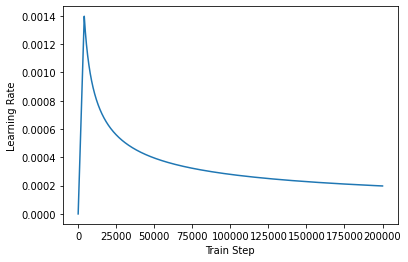

In [0]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

### Compile Model


In [0]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  # ensure labels have shape (batch_size, MAX_LENGTH - 1)
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

In [0]:
model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           inputs[0][0]                     
__________________________________________________________________________________________________
decoder (Model)                 (None, None, 256)    9172736     inputs[0][0]                     
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 19359)  4975263     decoder[1][0]          

## Checkpointing

In [0]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [0]:
EPOCHS = 30

model.fit(jokes_dataset, epochs=EPOCHS, callbacks = [checkpoint_callback])

Epoch 1/30
1250/1250 [==============================] - 221s 177ms/step - loss: 2.8174 - accuracy: 0.0371
Epoch 2/30
1250/1250 [==============================] - 218s 175ms/step - loss: 2.2466 - accuracy: 0.0749
Epoch 3/30
1250/1250 [==============================] - 220s 176ms/step - loss: 2.1542 - accuracy: 0.0820
Epoch 4/30
1250/1250 [==============================] - 221s 177ms/step - loss: 2.1158 - accuracy: 0.0841
Epoch 5/30
1250/1250 [==============================] - 220s 176ms/step - loss: 2.0609 - accuracy: 0.0876
Epoch 6/30
1250/1250 [==============================] - 221s 177ms/step - loss: 2.0156 - accuracy: 0.0903
Epoch 7/30
1250/1250 [==============================] - 221s 177ms/step - loss: 1.9764 - accuracy: 0.0928
Epoch 8/30
1250/1250 [==============================] - 221s 177ms/step - loss: 1.9409 - accuracy: 0.0951
Epoch 9/30
1250/1250 [==============================] - 222s 178ms/step - loss: 1.9099 - accuracy: 0.0972
Epoch 10/30
1250/1250 [=======================

KeyboardInterrupt: ignored

In [0]:
def exploit_best_token_while_exploring(probabilites, exploration_len=5):
    ## Get the top k probabilites indices where k is exploration_len 
    top_indices = np.argpartition(probabilites, -exploration_len)\
                            [-exploration_len:]

    ## Getting top proabilities value
    top_probabilities = probabilites[top_indices]

    print(top_probabilities)
    
    ## Normalizing it so that they sum is 1
    top_probabilities = top_probabilities / np.sum(top_probabilities)
    ## Although we choose next token randomly for our options we 
    ## pass the probabilities associated with each to account for the
    ## model's confidence for the token also. 
    choice = np.random.choice(exploration_len, 1, p = top_probabilities)

    ## Return next token id based on choice
    next_token_id = int(top_indices[choice][0])
    return next_token_id

In [0]:
def evaluate(sentence, MAX_LEN = 64):
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence), axis=0)

  output = sentence
  

  for i in range(MAX_LEN):
    predictions = model(inputs=output, training=False)

    # select the last word from the seq_len dimension
    predictions = predictions[0, -1]
    softmax_logits = tf.nn.softmax(predictions, axis=0).numpy()

    if i < 3:
      explore = 6
    else:
      explore = 3

    predicted_id = exploit_best_token_while_exploring(softmax_logits, 
                                                         explore)
    # return the result if the predicted_id is equal to the end token
    if tf.equal(predicted_id, END_TOKEN[0]) or tf.equal(predicted_id, START_TOKEN[0]):
      print("Match")
      break

    # concatenated the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([sentence,tf.ones((1,1), dtype = tf.int32)*predicted_id], axis=-1)
    sentence = output

  return tf.squeeze(sentence, axis=0)

In [0]:
output = evaluate("i am not ")

[0.01898067 0.02550635 0.05840998 0.03265192 0.02674519 0.14119545]
[0.01539614 0.0155585  0.03531409 0.31884107 0.03670638 0.20910487]
[0.01163651 0.01418181 0.01589158 0.0191134  0.03440016 0.07530235]
[0.04353283 0.05307201 0.16041845]
[0.04677405 0.06928442 0.08560692]
[0.02194401 0.02588431 0.18511719]
[0.07288094 0.16576831 0.23120983]
[0.03247977 0.0350408  0.03532861]
[0.04657497 0.09863608 0.10327204]
[0.05216319 0.07375689 0.6352417 ]
[0.0631812  0.07415269 0.11893477]
[0.03806804 0.17038152 0.68208784]
[0.01990407 0.02230101 0.02532276]
[0.03645616 0.1433049  0.0664776 ]
[0.04680076 0.13013639 0.5134725 ]
[0.05485788 0.10937466 0.09047744]
[0.06769039 0.17097935 0.5928441 ]
[0.01777232 0.0243126  0.01998525]
[0.03326371 0.06127982 0.06741346]
[0.03360926 0.1179401  0.35592774]
[0.01729194 0.01898156 0.02469221]
[0.03213741 0.04253787 0.04831379]
[0.08646292 0.17546579 0.56992763]
[0.00352956 0.9884829  0.00655812]
[0.01160213 0.03655864 0.05256154]
[0.04980678 0.05404642 0.3

In [0]:
tokenizer.decode(output.numpy()[1:])

"i am not like a woman I am like my first time I like my wife and I like my kids and my mom else's dick in my house."